# Negative Fake Companion Technique 
## Using GPU

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import numpy as np
import os

from vip_hci.fits import open_fits

from plottools import create_circular_mask 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import gpu.fake_comp as tfnegfc


os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [3]:
root = './data/DHTau_fake//'

cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 80, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (2, 3, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


### Normalizing PSF: Creating a template to mimic companions 

The first step consists in creating the fake companion template we will use later to mimic the real one.

We need first to find the real center and standard deviation of the PSF by fitting a gaussian model on pixels, 

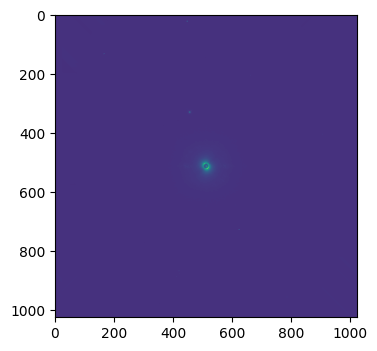

In [4]:
plt.figure(dpi=100)
plt.imshow(cube[0, 0])

In [5]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])

2023-05-10 21:42:24.678470: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-10 21:42:24.679532: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-10 21:42:24.679545: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas


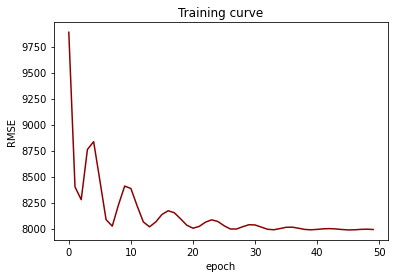

In [6]:
plt.plot(results['history'], color='darkred')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Training curve')
plt.show()

Assuming an sphere (i.e., same FWHM along the PSFs) we center all the availables PSFs. This is not used yet, but worth for future work:

In [7]:
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
centered_psf.shape

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


TensorShape([3, 64, 64])

Once all the PSFs were aligned we can normalize it to have a 1-FWHM in an aperture equal to FWHM//2

In [8]:
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

### PCA: Extracting most variable pixels along the time axis from the cube of frames

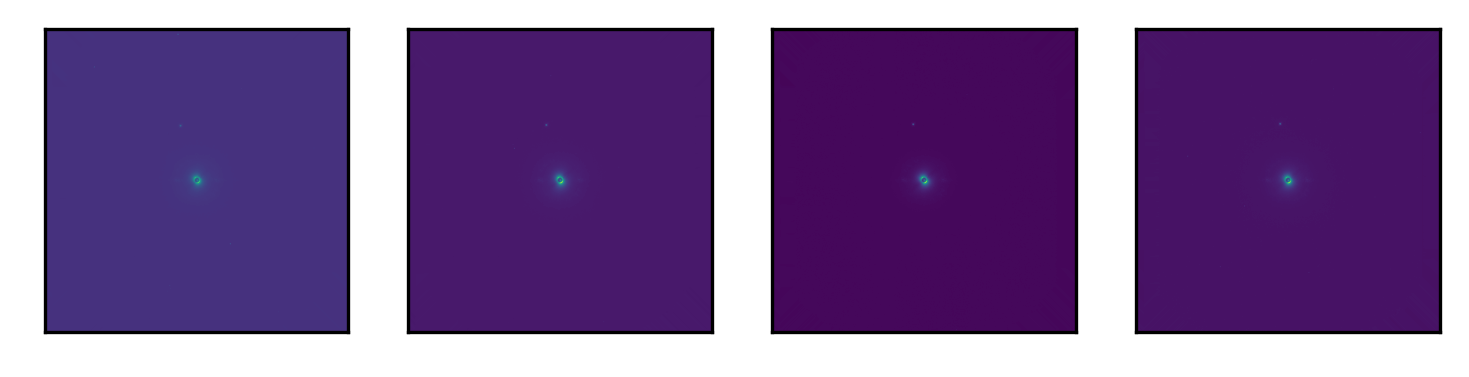

In [9]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, dpi=300)
axes = axes.flatten()
for i, nf in enumerate(range(0, len(cube[0]), 10)):
    try:
        axes[i].imshow(cube[0, nf])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    except:
        break

In [10]:
cube[0].shape

(80, 1024, 1024)

In [11]:
%%time
adi_image = tfnegfc.apply_adi(cube[0], rot_ang, out_size=cube[0].shape, ncomp=1, derotate='tf')

CPU times: user 1.13 s, sys: 1.16 s, total: 2.29 s
Wall time: 2.84 s


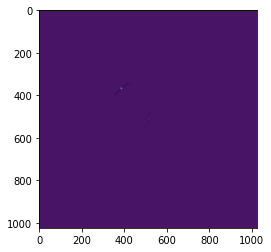

In [12]:
plt.imshow(adi_image)

In [13]:
%%time
table = tfnegfc.get_coords(adi_image.numpy(), fwhm=fwhm_sphere, bkg_sigma=5, cut_size=10)

CPU times: user 8.43 s, sys: 74 ms, total: 8.51 s
Wall time: 8.39 s


In [14]:
table

,x,y,flux,fwhm_mean,snr
0,386.426361,367.135071,27.748566,4.063258,51.818736
1,503.281799,506.804626,0.855316,2.377003,1.845787
2,503.608063,518.126343,0.606155,3.675333,1.592827
3,300.535309,399.108002,0.260184,4.560802,42.229910
4,513.070435,554.878113,0.174453,5.702513,2.040512
5,517.030640,546.720764,0.170452,5.012369,1.882586
6,459.859802,550.403442,0.161194,6.930309,3.070471
7,504.411469,472.870697,0.137701,3.301007,0.874955
8,461.543396,543.040527,0.134699,6.379152,2.089734
9,550.993103,730.697815,0.132692,4.661236,17.399992


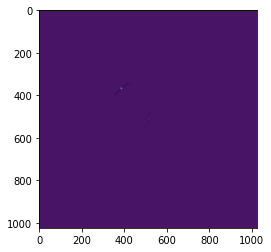

In [15]:
plt.figure()
plt.imshow(adi_image)
plt.show()

### Fiting parameters

In [93]:
# min_val = tf.expand_dims(tf.expand_dims(tf.reduce_min(cube[0], axis=[1, 2]), 1), 2)
# max_val = tf.expand_dims(tf.expand_dims(tf.reduce_max(cube[0], axis=[1, 2]), 1), 2)

# a = (cube[0] - min_val)/(max_val - min_val)
# fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, dpi=200)
# axes = axes.flatten()
# axes[0].imshow(a[0])
# axes[1].imshow(cube[0, 0])
# fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, dpi=200)
# axes[0].hist(a[0])
# axes[1].hist(cube[0,0])

In [94]:
from tensorflow.keras.optimizers import Adam 
from gpu.negfc_models import get_model
from gpu.losses import custom_loss
from gpu.data import get_dataset

In [95]:
def wrapper(fn, fwhm):
    def inner(*args):
        out = fn(*args, fwhm=fwhm)
        return out
    return inner

In [96]:
custom_loss_w = wrapper(custom_loss, fwhm=table.iloc[0]['fwhm_mean']*3)

dataset, (minv, maxv) = get_dataset(cube, normalized_psf, rot_ang)

model = get_model(x_init=table.iloc[0]['x'], 
                  y_init=table.iloc[0]['y'], 
                  cube=cube)    
model.compile(loss_fn=custom_loss_w, optimizer=Adam(1))
# model.summary()

In [97]:
hist = model.fit(dataset, epochs=200)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: -9.2021
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: -9.2024
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: -9.2026
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: -9.2028
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: -9.2029
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: -9.2031
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: -9.2033
Epoch 8/200
1/1 [==============================] - 1s 1s/step - loss: -9.2034
Epoch 9/200
1/1 [==============================] - 1s 1s/step - loss: -9.2035
Epoch 10/200
1/1 [==============================] - 1s 1s/step - loss: -9.2036
Epoch 11/200
1/1 [==============================] - 1s 1s/step - loss: -9.2037
Epoch 12/200
1/1 [==============================] - 1s 1s/step - loss: -9.2037
Epoch 13/200
1/1 [==============================] - 1s 1s/ste

1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 105/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 106/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 107/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 108/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 109/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 110/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 111/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 112/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 113/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 114/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 115/200
1/1 [==============================] - 1s 1s/step - loss: -9.2039
Epoch 116/200
1/1 [==============================] - 1

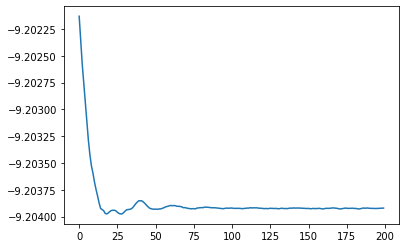

In [98]:
plt.plot(hist.history['loss'])

In [107]:
x = model.trainable_variables[0]
y = model.trainable_variables[1]
flux = model.trainable_variables[2][0]*(maxv[0]-minv[0]) + minv[0]
flux = flux[0][0]
print('flux: {}'.format(flux))

flux: -933.0829467773438


In [108]:
fake_zeros = tfnegfc.inject_fake(x=x, y=y, flux = -flux, 
                                cube=tf.zeros_like(cube[0]), 
                                patch=patch, 
                                rot_angles=rot_ang)
adi_image_fake_zeros = tfnegfc.apply_adi(fake_zeros, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

In [109]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_cube = tfnegfc.inject_fake(x=x, y=y, flux = -flux, 
                                cube=cube[0], 
                                patch=patch, 
                                rot_angles=rot_ang)

adi_image_fake = tfnegfc.apply_adi(fake_cube, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

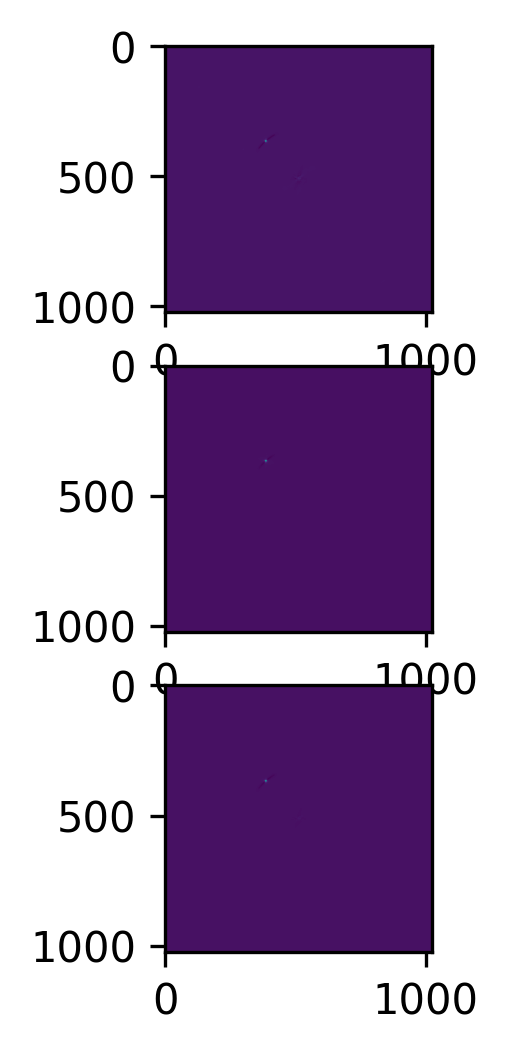

In [112]:
fig, axes = plt.subplots(3, 1, dpi=300)
axes[0].imshow(adi_image)
axes[1].imshow(adi_image_fake_zeros)
axes[2].imshow(adi_image+adi_image_fake_zeros)
# plt.scatter(x, y, marker='x', color='red')

### MCMC

In [59]:
import tensorflow_probability as tfp
import tensorflow as tf

In [60]:
def log_prob_flux_only(flux):        
    rv_flux = tfp.distributions.Normal(loc=flux, scale=2)
    if tf.math.less(flux, 0.):
        return -np.inf
    return rv_flux.log_prob(flux)

def log_prob_fn(x, y, flux):        
    rv_x = tfp.distributions.Normal(loc=x, scale=.1)
    rv_y = tfp.distributions.Normal(loc=y, scale=.1)
    rv_flux = tfp.distributions.Normal(loc=flux, scale=1)
    return (rv_x.log_prob(x) + rv_y.log_prob(y) + rv_flux.log_prob(flux))

In [61]:
def likelihood_flux_only(flux, x, y, fwhm, cube, patch, rot_ang):    
    fake_cube = tfnegfc.inject_fake(x=x, 
                                    y=y, 
                                    flux = -flux, 
                                    cube=cube, 
                                    patch=patch, 
                                    rot_angles=rot_ang)
    obj_reg = tfnegfc.get_objective_region(fake_cube, x=x, y=y, rot_ang=rot_ang, fwhm=fwhm, nfwhm=1)
    return -tf.math.reduce_std(obj_reg)

def likelihood_fn(x, y, flux, fwhm, cube, patch, rot_ang):    
    fake_cube = tfnegfc.inject_fake(x=x, 
                                    y=y, 
                                    flux = -flux, 
                                    cube=cube, 
                                    patch=patch, 
                                    rot_angles=rot_ang)
    obj_reg = tfnegfc.get_objective_region(fake_cube, x=x, y=y, rot_ang=rot_ang, fwhm=fwhm, nfwhm=1)
    return -tf.math.reduce_std(obj_reg)

In [62]:
def joint_log_prob_fn(x, y, flux, fwhm, cube, patch, rot_angle):
    
    return log_prob_fn(x, y, flux) + likelihood_fn(x,y,flux, fwhm, cube, patch, rot_angle)

def joint_log_prob_flux_only(flux, x, y, fwhm, cube, patch, rot_angle):
    
    return log_prob_flux_only(flux) + likelihood_flux_only(flux, x,y, fwhm, cube, patch, rot_angle)

In [63]:
@tf.function
def run_chain_only_flux(initial_state, x, y, fwhm, cube, normalized_psf, 
                        rot_ang, num_results=1000, num_burnin_steps=500):
    
    initial_state = [tf.cast(x, tf.float32) for x in initial_state]
    fake_patch = tfnegfc.create_patch(cube[0], normalized_psf)
        
    # Define a closure over our joint_log_prob.
    unconstraining_bijectors = [
      tfp.bijectors.Identity()
    ]
    unnormalized_posterior_log_prob = lambda *args: joint_log_prob_flux_only(*args, x, y, 
                                                                             fwhm, cube, 
                                                                             fake_patch,
                                                                             rot_ang)
    
    # Define the HMC transition kernel.
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_posterior_log_prob,
      num_leapfrog_steps=2,
      step_size=0.1)
    
    # Define the MCMC transition kernel.
    mcmc_kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc_kernel,
      bijector=unconstraining_bijectors)
    
    # Define the initial state of the chain.
    current_state = initial_state
    
    # Sample from the chain.
    samples = tfp.mcmc.sample_chain(
                  num_results=num_results,
                  num_burnin_steps=num_burnin_steps,
                  current_state=current_state,
                  kernel=mcmc_kernel)
    return samples

@tf.function
def run_chain(initial_state, fwhm, cube, normalized_psf, rot_ang, num_results=1000, num_burnin_steps=500):
    initial_state = [tf.cast(x, tf.float32) for x in initial_state]
    fake_patch = tfnegfc.create_patch(cube[0], normalized_psf)
        
    # Define a closure over our joint_log_prob.
    unconstraining_bijectors = [
      tfp.bijectors.Identity(),
      tfp.bijectors.Identity(),
      tfp.bijectors.Identity()
    ]
    unnormalized_posterior_log_prob = lambda *args: joint_log_prob_fn(*args, fwhm, cube, fake_patch,rot_ang)
    
    # Define the HMC transition kernel.
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_posterior_log_prob,
      num_leapfrog_steps=2,
      step_size=0.1)
    
    # Define the MCMC transition kernel.
    mcmc_kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc_kernel,
      bijector=unconstraining_bijectors)
    
    # Define the initial state of the chain.
    current_state = initial_state
    
    # Sample from the chain.
    samples = tfp.mcmc.sample_chain(
                  num_results=num_results,
                  num_burnin_steps=num_burnin_steps,
                  current_state=current_state,
                  kernel=mcmc_kernel)
    return samples

In [43]:
# %%time
# init_state = [table.iloc[0]['x'], table.iloc[0]['y'], table.iloc[0]['flux']]
# results = run_chain(init_state, table.iloc[0]['fwhm_mean'], cube[0], normalized_psf[0], 
#                     rot_ang, num_results=1000)

In [64]:
%%time
init_state = [flux]

results = run_chain_only_flux(init_state, 
                               table.iloc[0]['x'], 
                               table.iloc[0]['y'], 
                               table.iloc[0]['fwhm_mean'], 
                               cube[0], 
                               normalized_psf[0], 
                               rot_ang, 
                               num_results=10000)

/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


ValueError: in user code:

    File "/tmp/ipykernel_17768/2400159539.py", line 32, in run_chain_only_flux  *
        samples = tfp.mcmc.sample_chain(
    File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py", line 359, in sample_chain  **
        (_, _, final_kernel_results), (all_states, trace) = loop_util.trace_scan(
    File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/internal/loop_util.py", line 222, in trace_scan
        _, final_state, _, trace_arrays = tf.while_loop(
    File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/internal/loop_util.py", line 212, in _body
        state = loop_fn(state, elem)
    File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py", line 352, in _trace_scan_fn
        seed, next_state, current_kernel_results = loop_util.smart_for_loop(
    File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/internal/loop_util.py", line 97, in smart_for_loop
        return tf.while_loop(

    ValueError: Input tensor `mcmc_sample_chain/trace_scan/while/Placeholder_2:0` enters the loop with shape (1,), but has shape <unknown> after one iteration. To allow the shape to vary across iterations, use the `shape_invariants` argument of tf.while_loop to specify a less-specific shape.


In [45]:
start = 800
samples = [r[start:] for r in results.all_states]
opt_values = [np.mean(samples_chain) for samples_chain in samples]

for initial_val, final_val in zip(init_state, opt_values):
    print(initial_val,' - ', final_val)

27.748563766479492  -  20.021292


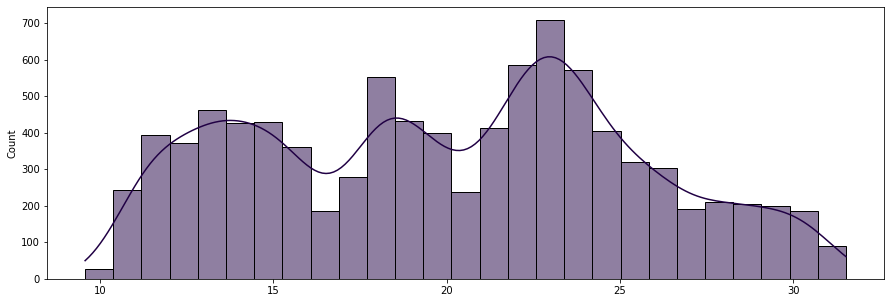

In [46]:
import seaborn as sns
fig, axes = plt.subplots(1, len(init_state), figsize=(15,5))
if len(init_state)>1: 
    axes = axes.flatten()
else:
    axes = [axes]
for i, r in enumerate(samples):
    sns.histplot(r, ax=axes[i], kde=True, color='#200044')

## Visualizing Results

In [49]:
x_star = table.iloc[0]['x']
y_star = table.iloc[0]['y']
flux_star = opt_values[0]

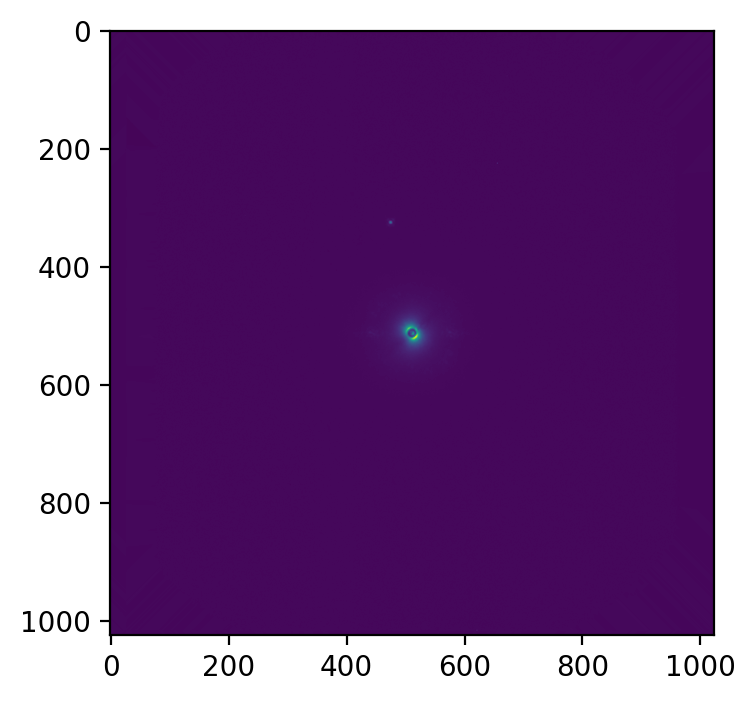

In [50]:
fake_patch = tfnegfc.create_patch(tf.squeeze(cube[0, 0]), normalized_psf[0])

fake_cube = tfnegfc.inject_fake(x = x_star, 
                                y = y_star, 
                                flux  = -flux_star, 
                                cube  = cube[0], 
                                patch = fake_patch, 
                                rot_angles = rot_ang)

plt.figure(dpi=200)
plt.imshow(fake_cube[20])
# plt.ylim(200, 400)
# plt.xlim(400, 600)

In [51]:
adi_image_2 = tfnegfc.apply_adi(fake_cube, rot_ang, ncomp=1, derotate='tf')

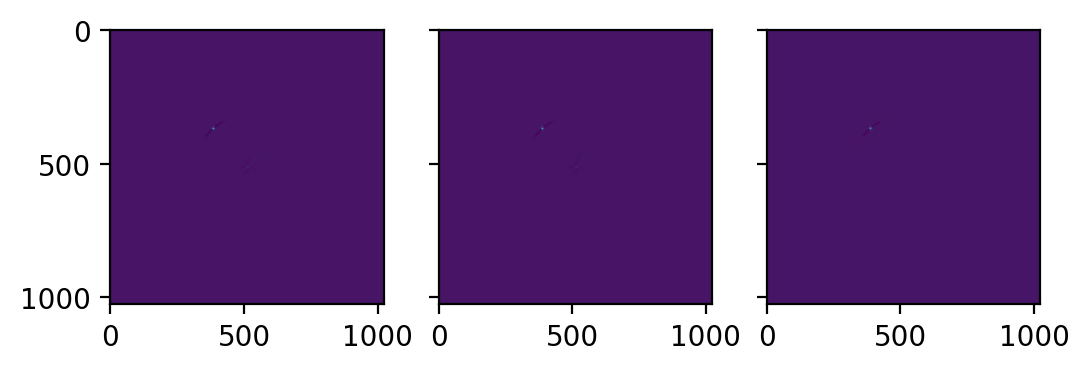

In [52]:
fig, axes = plt.subplots(1, 3, dpi=200, sharex=True, sharey=True)
axes[0].imshow(adi_image)
axes[1].imshow(adi_image_2)
axes[2].imshow(adi_image-adi_image_2)